<a href="https://colab.research.google.com/github/aleks-haksly/KarpovCources_Hard_DA_advanced/blob/main/04%20-%20ML/03_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
!pip install clickhouse-driver --q
from clickhouse_driver import Client
from google.colab import userdata

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Реквизиты для подключения к БД
user = 'hardda_student_alekse-fomin'
password = userdata.get('HA[hardda_student_alekse-fomin]')

host='clickhouse.lab.karpov.courses'
port=9000
database_r='hardda' # БД с правами только на чтение

In [ ]:
# Создаем соединение с БД ClickHouse
client_r = Client(host=host, port=port, user=user,
                password=password, database=database_r)

In [ ]:
#
sql = """
WITH filtered_data as (SELECT * FROM hardda.live_adverts
WHERE execution_date between '2022-10-01' and '2022-11-01'
AND region = 'Красноярск' AND year != '0' AND created_at < '2022-10-02')


SELECT t1.*, 0 as chorn FROM filtered_data t1
INNER JOIN filtered_data t2
ON t1.passport_id = t2.passport_id
WHERE t1.execution_date = '2022-10-01' AND t2.execution_date = '2022-11-01'

UNION DISTINCT

SELECT t3.*, 1 as chorn FROM filtered_data t3
INNER JOIN filtered_data t4
ON t3.passport_id = t4.passport_id
WHERE t3.execution_date = '2022-10-01' AND t4.passport_id NOT IN (SELECT passport_id FROM filtered_data WHERE execution_date BETWEEN '2022-10-18' AND '2022-11-01')


"""
result, columns = client_r.execute(sql, with_column_types=True)
data = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])


In [ ]:
data['execution_date'] = pd.to_datetime(data['execution_date'], format='%Y-%m-%d')
data['created_at'] = pd.to_datetime(data['created_at'], format='%Y-%m-%d')

## Задача 1. Подбор признаков (1/7)


Посчитайте количество живых объявлений для каждого пользователя на дату execution_date=='2022-10-01'. Если их много, и продавец даже потенциально может утечь, то, вероятно, не в этом месяце.

Создайте такой признак, назовите его 'opening_adverts_amount'.

Сколько всего живых объявлений получилось?

In [ ]:
df = data.groupby('passport_id', as_index=False).agg({'advert_id': 'count', 'chorn': 'max'}).rename(columns={'advert_id': 'opening_adverts_amount'})
df.head()

,passport_id,opening_adverts_amount,chorn
0,123467852,1,0
1,123469843,4,0
2,123475067,2,0
3,123476026,1,0
4,123478402,2,1


In [ ]:
live_adverts = df.opening_adverts_amount.sum()
print(f"Число живых объявлений на 2022-10-01 = {live_adverts}")

Число живых объявлений на 2022-10-01 = 4503


## Задача 1. Подбор признаков (2/7)


Посчитайте их средний чек (среднюю цену объявления на пользователя) с ценами на execution_date=='2022-10-01'. Влияние такого признака неочевидное: может быть, он окажется полезным, так как luxury goods обычно продаются дольше.

Создайте такой признак, назовите его 'price'

Какой наибольший средний чек нашли в полученном датасете?

In [ ]:
df = pd.merge(df, data.query("execution_date == '2022-10-01'").groupby('passport_id', as_index=False).agg({'price': 'mean'}), on='passport_id', how='left')

In [ ]:
df

,passport_id,opening_adverts_amount,chorn,price
0,123467852,1,0,1900000.0
1,123469843,4,0,1720000.0
2,123475067,2,0,10250000.0
3,123476026,1,0,2400000.0
4,123478402,2,1,2600000.0
...,...,...,...,...
3736,144333596,1,0,400000.0
3737,144333976,1,1,40000.0
3738,144334504,1,1,84000.0
3739,144334622,1,1,500000.0


In [ ]:
print(f"наибольший средний чек = {df.price.max()}")

наибольший средний чек = 24000000.0


## Задача 1. Подбор признаков (3/7)


Посчитайте средний возраст автомобилей в годах простой разницей (если автомобиль 2019 года, то считаем, что автомобилю 3 год). Совсем старые автомобили могут обладать сильным износом и долго продаваться.

Создайте такой признак, назовите его 'auto_age'

Какая медиана среднего возраста автомобиля по passport_id?

In [ ]:
data['auto_age'] = data.execution_date.dt.year.max() - data.year.astype(int)
df = pd.merge(df, data.groupby('passport_id', as_index=False).agg({'auto_age': 'mean'}), on='passport_id', how='left')

In [ ]:
print(f"медиана среднего возраста автомобиля по passport_id = {df.auto_age.median()}")

медиана среднего возраста автомобиля по passport_id = 14.0


## Задача 1. Подбор признаков (4/7)


Посчитайте средний возраст объявлений пользователя на момент execution_date=='2022-10-01' в днях (игнорируем время создания объявления). Если объявления висят достаточно давно, то, при прочих равных, они аккумулировали достаточное количество просмотров, и сделка может находиться в стадии заключения. Если продавец – обычное физическое лицо, то после продажи автомобиля он может навсегда пропасть с платформы.

Создайте такой признак, назовите его 'advert_age'

Какой наибольший средний возраст объявления нашли в полученном датасете?

In [ ]:
data['advert_age'] = (data.execution_date.dt.date - data.created_at.dt.date).apply(lambda x: x.days)

In [ ]:
df = pd.merge(df, data.groupby('passport_id', as_index=False).agg({'advert_age': 'mean'}), on='passport_id', how='left')
df.head()

,passport_id,opening_adverts_amount,chorn,price,auto_age,advert_age
0,123467852,1,0,1900000.0,19.0,11.00
1,123469843,4,0,1720000.0,16.0,660.25
2,123475067,2,0,10250000.0,7.5,632.00
3,123476026,1,0,2400000.0,14.0,2772.00
4,123478402,2,1,2600000.0,8.0,4.00


In [ ]:
print(f"наибольший средний возраст объявления = {df.advert_age.max()}")

наибольший средний возраст объявления = 2881.0


## Задача 1. Подбор признаков (5/7)


Создайте признак с "наиболее популярной платформой" у пользователя. Не ожидаем, что признак будет полезным, но, может быть, его влияние окажется для нас интересным инсайтом.

Если нельзя однозначно определить наиболее популярную платформу, то отдавайте предпочтение android > ios > desktop > unknown > mobile для целостности подхода.

Создайте такой признак, назовите его 'platform'

In [ ]:
data['platform'] = data.platform.fillna('unknown')

In [ ]:
d = {"android": 5,  'ios': 4,  "desktop":3, "unknown": 2, "mobile": 1}
reversed_d = {v: k for k, v in d.items()}

In [ ]:
data.platform = data.platform.map(d)

In [ ]:
data.groupby(['passport_id', 'platform'], group_keys=False).agg({'platform': 'count'}).rename(columns={'platform': 'platform_count'}).\
groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(by=['platform_count', 'platform'], ascending=False).index[0][1]).reset_index().\
groupby(0).agg('count').reset_index().rename(columns={0: 'platform', 'passport_id': 'count'}).set_index("count").map(lambda x: reversed_d.get(x))

,platform
count,
1,unknown
126,desktop
1144,ios
2470,android


In [ ]:
df_platforms = data.groupby(['passport_id', 'platform'], group_keys=False).agg({'platform': 'count'}).rename(columns={'platform': 'platform_count'}).\
groupby(level=0, group_keys=False).apply(lambda x: x.sort_values(by=['platform_count', 'platform'], ascending=False).index[0][1]).map(reversed_d).reset_index().rename(columns={0: 'platform'})
df_platforms.head()

,passport_id,platform
0,123467852,android
1,123469843,desktop
2,123475067,android
3,123476026,desktop
4,123478402,ios


In [ ]:
df = pd.merge(df, df_platforms, on='passport_id', how='left')
df.head()

,passport_id,opening_adverts_amount,chorn,price,auto_age,advert_age,platform
0,123467852,1,0,1900000.0,19.0,11.00,android
1,123469843,4,0,1720000.0,16.0,660.25,desktop
2,123475067,2,0,10250000.0,7.5,632.00,android
3,123476026,1,0,2400000.0,14.0,2772.00,desktop
4,123478402,2,1,2600000.0,8.0,4.00,ios


## Задача 1. Подбор признаков (6/7)


Создайте признак "есть ли среди объявлений пользователя машины, наиболее популярные в плане размещения на платформе на дату execution_date=='2022-10-01'?

Популярным объявлением считается факт вхождения модели автомобиля в топ-10 размещенных объявлений в текущую дату. "Ходовые" товары обычно продаются быстрее, и рынок (предложение) заполняется ими соответствующими темпами. Unknown model не учитывайте при составлении топа, модели (текст) нормализовать не нужно – возьмите как они есть в таблице.

Создайте такой признак, назовите его 'is_top_model'

У какого числа passport_id, действительно, среди объявлений на указанную дату есть популярные объявления?

In [ ]:
top_models = data.auto_model.value_counts().head(11).index.to_list()[1:]

In [ ]:
top_models

['Camry',
 '2110 (седан)',
 '2114 (хэтчбек)',
 'Passat',
 'ГАЗель',
 'Granta 2190 (седан)',
 'Priora 2170 (седан)',
 '2112 (хэтчбек)',
 '2121 Нива',
 'Priora 2172 (хэтчбек)']

In [ ]:
data['is_top_model'] = data.auto_model.apply(lambda x: 1 if x in top_models else 0)

In [ ]:
top_count = data.groupby('passport_id', as_index=False).agg({'is_top_model': 'max'}).query("is_top_model > 0").is_top_model.count()

In [ ]:
df = pd.merge(df, data.groupby('passport_id', as_index=False).agg({'is_top_model': 'max'}), on='passport_id', how='left')

In [ ]:
print(f"среди объявлений на указанную дату у {top_count} passport_id есть популярные объявления")

среди объявлений на указанную дату у 1109 passport_id есть популярные объявления


## Задача 1. Подбор признаков (7/7)


Добавьте признак user_type_cars_name из таблицы user_passports по ключу passport_id.

Какой наименее популярный тип пользователя оказался? Сколько там пользователей?

Введите название типа и количество пользователей через запятую и пробел

In [ ]:
#
sql = """
SELECT passport_id,  user_type_cars_name FROM user_passports


"""
result, columns = client_r.execute(sql, with_column_types=True)
user_type_cars_name_df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])

In [ ]:
data = pd.merge(data, user_type_cars_name_df, on='passport_id', how='left')

In [ ]:
df = pd.merge(df, user_type_cars_name_df, on='passport_id', how='left')
df.head()

,passport_id,opening_adverts_amount,chorn,price,auto_age,advert_age,platform,is_top_model,user_type_cars_name
0,123467852,1,0,1900000.0,19.0,11.00,android,0,cars_simple
1,123469843,4,0,1720000.0,16.0,660.25,desktop,0,cars_simple
2,123475067,2,0,10250000.0,7.5,632.00,android,0,cars_simple
3,123476026,1,0,2400000.0,14.0,2772.00,desktop,0,cars_simple
4,123478402,2,1,2600000.0,8.0,4.00,ios,1,cars_simple


## Задача 2. Автоматическая обработка данных (1/4)


С базовыми фичами закончили! Теперь пора отфильтровать пропуски при необходимости и подготовить дефолтный трансформер для обработки фичей.

В какой единственной колонке отсутствуют значения и сколько там пропусков?

Пропусков немного, поэтому выбрасывать наблюдения или избавляться от колонки не будем.

Введите название колонки и количество пропусков через запятую и пробел:

In [ ]:
df.isna().sum().rename('na_count').to_frame().query("na_count > 0")

,na_count
user_type_cars_name,109


## Задача 2. Автоматическая обработка данных (2/4)


Для воспроизводимости результатов отсортируйте полученный датафрейм по возрастанию passport_id.

Разделите выборку на объекты (X) и таргеты (y).

Можете сразу удалить столбец passport_id из X, чтобы не тащить этот шаг обработки в трансформер.

Насколько сбалансированные классы к предсказанию получились?

Какое минимальное accuracy мы бы хотели ожидать от финальной модели (округлите до сотых)?

In [ ]:
df = df.sort_values(by='passport_id').reset_index(drop=True)

In [ ]:
df

,passport_id,opening_adverts_amount,chorn,price,auto_age,advert_age,platform,is_top_model,user_type_cars_name
0,123467852,1,0,1900000.0,19.0,11.00,android,0,cars_simple
1,123469843,4,0,1720000.0,16.0,660.25,desktop,0,cars_simple
2,123475067,2,0,10250000.0,7.5,632.00,android,0,cars_simple
3,123476026,1,0,2400000.0,14.0,2772.00,desktop,0,cars_simple
4,123478402,2,1,2600000.0,8.0,4.00,ios,1,cars_simple
...,...,...,...,...,...,...,...,...,...
3736,144333596,1,0,400000.0,7.0,0.00,android,0,cars_simple
3737,144333976,1,1,40000.0,19.0,0.00,ios,1,cars_simple
3738,144334504,1,1,84000.0,16.0,0.00,ios,1,cars_simple
3739,144334622,1,1,500000.0,23.0,0.00,android,0,cars_simple


In [ ]:
X = df.drop(columns=['passport_id', 'chorn'])
y = df.chorn

In [ ]:
print(f"минимальное accuracy мы бы хотели ожидать от финальной модели = {y.value_counts(normalize=True).max():.2f}")

минимальное accuracy мы бы хотели ожидать от финальной модели = 0.78


## Задача 2. Автоматическая обработка данных (3/4)


Подготовьте стратегию валидации (возьмите обыкновенный `KFold` с параметрами `shuffle=True, random_state=42` и `3 фолдами`).

И затем реализуйте базовый трансформер название, который

1. Заполняет пропуск самым популярным значением

2. Применяет OHE-encoding к категориальным фичам.

3. Делает MinMax scaling

Для OneHotEncoder добавьте параметры `drop='first'` и `handle_unknown='ignore'` (вспомните, для чего нужен каждый из них).

Для ColumnTransformer добавьте `verbose_feature_names_out=False`, чтобы имена столбцов были в "простом" формате.

Прикрепите датафрейм с признаками, полученный с помощью метода `fit_transform` у трасформера:

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.compose import make_column_selector as selector
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
imputer_most_popular = ColumnTransformer(
    transformers=[
        ('SimpleImputer', SimpleImputer(strategy='most_frequent'), selector(dtype_exclude='number'))
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [ ]:
ohe = ColumnTransformer(
    transformers=[
        ('OneHotEncoder', OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore'), selector(dtype_exclude='number'))
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [ ]:
minmax_scaler = ColumnTransformer(
    transformers=[
        ('MinMaxScaler', MinMaxScaler(),selector(dtype_include='number'))
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform='pandas')

In [ ]:
final_process_pipeline = Pipeline([
        ('imputer_most_popular', imputer_most_popular),
        ('ohe', ohe),
        ('minmax_scaler', minmax_scaler)
    ])

In [ ]:
transformed_dt = X_transformed = final_process_pipeline.fit_transform(X)

In [ ]:
transformed_dt.to_csv('transformed_dt.csv', index=False)

In [ ]:
X_transformed = transformed_dt
transformed_dt.head()

,platform_desktop,platform_ios,platform_unknown,user_type_cars_name_cars_seller,user_type_cars_name_cars_simple,opening_adverts_amount,price,auto_age,advert_age,is_top_model
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.079167,0.316667,0.003818,0.0
1,1.0,0.0,0.0,0.0,1.0,0.125000,0.071667,0.266667,0.229174,0.0
2,0.0,0.0,0.0,0.0,1.0,0.041667,0.427083,0.125000,0.219368,0.0
3,1.0,0.0,0.0,0.0,1.0,0.000000,0.100000,0.233333,0.962166,0.0
4,0.0,1.0,0.0,0.0,1.0,0.041667,0.108333,0.133333,0.001388,1.0


## Задача 3. Обучение и выбор модели (1/4)


Поэкспериментируем с Логистической Регрессией и SVM-классификатором с сетками гиперпараметров, которые фиксировали в уроке.

Будем выбирать модель с кастомной метрикой, как делали в уроке. Только теперь развернем ситуацию - хотим максимальный precision с условием, что recall модели будет >90%.

Заметьте, что в данном случае метрики тоже зависят от threshold'а моделей. А значит, нужно будет (как делали в уроке) модифицировать классы Логистической Регрессии и SVM-классификатора, чтобы использовать threshold как гиперпараметр.

Напишите классы `SVMClassifier()` и `LogRegClassifier()`, которые возвращают прогнозы в соответствии с выбранным `threshold`. Установите для моделей параметр `random_state=42`.

Для логистической регрессии используйте следующие гиперпараметры:

* для C: [0.001, 0.01, 0.5, 1, 10, 100]
* для fit_intercept: [True, False]
* для penalty: ['l1', 'l2', 'elasticnet']
* для solver: ['lbfgs', 'newton-cg']
* threshold: [0.3, 0.5, 0.7]

Для SVM используйте следующие гиперпараметры:

* для C: [0.001, 0.01, 0.5, 1, 10, 100]
* для fit_intercept: [True, False]
* для loss: ['hinge', 'squared_hinge']
* threshold: [0.3, 0.5, 0.7]

Для подбора гиперпараметров моделей в `GridSearch` нужно передавать весь датасет, не разбивая его на train и test.

In [ ]:
from sklearn.model_selection import KFold
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV

In [ ]:
splitter = KFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

In [ ]:
lr_pipe = Pipeline(
    [
        ('all_preprocess', final_process_pipeline),
        ('simple_model', LogisticRegression(random_state=42))
    ]
)

svm_pipe = Pipeline(
    [
        ('all_preprocess', final_process_pipeline),
        ('simple_model', LinearSVC(random_state=42))
    ]
)

In [ ]:
### Сделаем сетку из параметров для GridSearch'а
### Напомню - если хочется посмотреть на сетку параметров у некоторого Estimator,
### То стоит применить к нему метод .get_params()
lr_grid = {
    'subestimator__simple_model__C' : [0.001, 0.01, 0.5, 1, 10, 100],  # Параметр регуляризации
    'subestimator__simple_model__fit_intercept': [True, False],        # Добавлять ли свободный коэффициент к уравнению гиперплоскости
    'subestimator__simple_model__penalty': ['l1', 'l2', 'elasticnet'], # Тип регуляризации
    'subestimator__simple_model__solver': ['lbfgs', 'newton-cg'],      # Алгоритм оптимизации
    'threshold': [0.3, 0.5, 0.7]                                       # Порог отсечения вероятности
}

svm_grid = {
    'subestimator__simple_model__C' : [0.001, 0.01, 0.5, 1, 10, 100], # Параметр регуляризации
    'subestimator__simple_model__fit_intercept': [True, False],       # Добавлять ли свободный коэффициент к уравнению гиперплоскости
    'subestimator__simple_model__loss': ['hinge', 'squared_hinge'],   # Есть опция выбрать квадратичный hinge loss
    'threshold': [0.3, 0.5, 0.7]                                      # Порог отсечения вероятности
}

In [ ]:
class LogRegClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5, subestimator=lr_pipe):
        self.threshold = threshold
        self.subestimator = subestimator


    def fit(self, X, y):

        ### Копируем матрицы X, y
        X, y = X.copy(), y.copy()

        ### Инициализируем LogReg
        self.subestimator.fit(X, y)

        ### Сохраняем таргеты в аттрибут класса, без этого потом не заведется GridSearchCV
        self.classes_ = self.subestimator.classes_
         ### Это пригодится для интерпретации
        self.coef_ = self.subestimator['simple_model'].coef_
        self.intercept_ = self.subestimator['simple_model'].intercept_

        self.X_ = X
        self.y_ = y

        return self


    def predict(self, X):

        ### Возвращаем прогнозы в соответствии с выбранным threshold!
        probas = self.subestimator.predict_proba(X)[:, 1] > self.threshold

        return probas.astype(int)


    def predict_proba(self, X):

        return self.subestimator.predict_proba(X)


lrc_modified = LogRegClassifier()

In [ ]:
### Класс для SVM с threshold'ом как гиперпараметром
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, threshold=0.5, subestimator=svm_pipe, calibration=CalibratedClassifierCV()):
        self.threshold = threshold
        self.subestimator = subestimator
        self.calibration = calibration


    def fit(self, X, y):

        ### Копируем матрицы X, y
        X, y = X.copy(), y.copy()

        ### Инициализируем калиброванный Estimator
        self.calibration.set_params(
            estimator=self.subestimator,
            method='isotonic',
            cv=3
        )
        self.calibration.fit(X, y)

        self.classes_ = self.calibration.classes_
        self.X_ = X
        self.y_ = y

        return self


    def predict(self, X):

        ### Возвращаем прогнозы в соответствии с выбранным threshold!
        probas = self.calibration.predict_proba(X)[:, 1] > self.threshold

        return probas.astype(int)


    def predict_proba(self, X):

        return self.calibration.predict_proba(X)


svmc_modified = SVMClassifier()

In [ ]:
### Первый шаг (необязательный) - функция для вывода результатов
def print_dataframe(filtered_cv_results):
    """Pretty print for filtered dataframe"""
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results['mean_test_precision'],
        filtered_cv_results['std_test_precision'],
        filtered_cv_results['mean_test_recall'],
        filtered_cv_results['std_test_recall'],
        filtered_cv_results['params'],
    ):
        print(
            f'precision: {mean_precision:0.3f} (±{std_precision:0.03f}),'
            f' recall: {mean_recall:0.3f} (±{std_recall:0.03f}),'
            f' for {params}'
        )
    print()

In [ ]:
### Функция для определения стратегии выбора лучших гиперпараметров
def refit_strategy(cv_results):

    # Recall threshold
    recall_threshold = 0.9

    # Результат работы всех наборов гиперпараметров по precision, recall
    cv_results_ = pd.DataFrame(cv_results)
    print('All grid-search results:')
    print_dataframe(cv_results_)

    # Убираем все модели, не прошедшие порог
    high_recall_cv_results = cv_results_[
        cv_results_['mean_test_recall'] > recall_threshold
    ]

    print(f'Models having Recall > {recall_threshold}:')
    print_dataframe(high_recall_cv_results)

    high_recall_cv_results = high_recall_cv_results[
        [
            'mean_score_time',
            'mean_test_recall',
            'std_test_recall',
            'mean_test_precision',
            'std_test_precision',
            'rank_test_recall',
            'rank_test_precision',
            'params',
        ]
    ]

   # Выбираем  лучшую модель среди найденных по precision метрике
    best_precision = high_recall_cv_results['mean_test_precision'].max()

    high_precision_cv_results = high_recall_cv_results[
        high_recall_cv_results['mean_test_precision'] == best_precision
    ]
    print('The best model:')
    print_dataframe(high_precision_cv_results)

    # Выбор индекса модели, попавшей в high_recall_cv_results
    # Если там содержится > 1 модели, то выбираем ту, которая работает быстрее всего
    fastest_top_precision_high_recall_index = high_precision_cv_results['mean_score_time'].idxmin()

    return fastest_top_precision_high_recall_index

## Задача 3. Обучение и выбор модели (2/4)


Далее вам необходимо будет, как и в уроке написать функцию для определения стратегии выбора лучших гиперпараметров. Затем сделать сетку из параметров для GridSearch'а и найти лучшие параметры GridSearch'а в терминах метрик precision и recall для моделей LogisticRegression и SVM.

Какой precision, recall и threshold у лучшего экземпляра Логистической Регрессии?

Введите полученные значения через запятую и пробел (precision и recall с точностью до 3 знаков).

In [ ]:
### Найдем лучшие параметры GridSearch'а в терминах некоторых метрик
### Для LogisticRegression
scores = ('precision', 'recall')

print('Looking for the best set of parameters for Logistic Regression model:')
search_lr = GridSearchCV(lrc_modified, lr_grid,
                         cv=splitter, scoring=scores,
                         refit=refit_strategy)

search_lr.fit(X_transformed, y)

Looking for the best set of parameters for Logistic Regression model:
All grid-search results:
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.3}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.5}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.7}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simp

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogRegClassifier(),
             param_grid={'subestimator__simple_model__C': [0.001, 0.01, 0.5, 1,
                                                           10, 100],
                         'subestimator__simple_model__fit_intercept': [True,
                                                                       False],
                         'subestimator__simple_model__penalty': ['l1', 'l2',
                                                                 'elasticnet'],
                         'subestimator__simple_model__solver': ['lbfgs',
                                                                'newton-cg'],
                         'threshold': [0.3, 0.5, 0.7]},
             refit=<function refit_strategy at 0x78a004d48ee0>,
             scoring=('precision', 'recall'))

The best model:
precision: 0.839 (±0.003), recall: 0.902 (±0.013), for {'subestimator__simple_model__C': 100, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l2', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.7}

## Задача 3. Обучение и выбор модели (3/4)


Какой precision, recall и threshold у лучшего экземпляра SVM-классификатора?

Введите полученные значения через запятую и пробел (precision и recall с точностью до 3 знаков).

In [ ]:
print("Поиск лучших параметров Метода Опорных Векторов:")
### SVM
scores = ('precision', 'recall')

search_svm = GridSearchCV(svmc_modified, svm_grid,
                          cv=splitter, scoring=scores,
                          refit=refit_strategy)

search_svm.fit(X_transformed, y)

Поиск лучших параметров Метода Опорных Векторов:
All grid-search results:
precision: 0.778 (±0.003), recall: 1.000 (±0.000), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.3}
precision: 0.779 (±0.003), recall: 0.996 (±0.005), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.5}
precision: 0.798 (±0.010), recall: 0.875 (±0.048), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.7}
precision: 0.778 (±0.003), recall: 0.999 (±0.001), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'squared_hinge', 'threshold': 0.3}
precision: 0.780 (±0.004), recall: 0.991 (±0.007), for {'subestimator__simple_

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVMClassifier(),
             param_grid={'subestimator__simple_model__C': [0.001, 0.01, 0.5, 1,
                                                           10, 100],
                         'subestimator__simple_model__fit_intercept': [True,
                                                                       False],
                         'subestimator__simple_model__loss': ['hinge',
                                                              'squared_hinge'],
                         'threshold': [0.3, 0.5, 0.7]},
             refit=<function refit_strategy at 0x78a004d48ee0>,
             scoring=('precision', 'recall'))

## Задача 4. Новый эксперимент (1/4)


Теперь попробуем добавить в датасет информацию о транзакционной активности клиентов!

Кажется, что различного рода транзакции (продажи/покупки и пр.) могут быть хорошим сигналом для оттока. Если клиент часто и объемно транзачит, то, скорее всего, с нашим сервисом его связывает больше вещей, чем продавцов, которые не пользуются премиальными услугами, не возобновляют подписки и так далее.

Посмотрите на клиентские транзакции в таблице `USER_TRANSACTIONS` за период между `'2022-09-01'` и `'2022-10-01'`, то есть за предыдущий месяц от момента прогноза в начале месяца.. Сгруппируйте суммы в три категории по следующему правилу:

1. Транзакции класса `revenue`, если `type in ('basic sale', 'fast sale', 'quick sale')`

2. Транзакции класса `renewal`, если `type in ('renewal', 'archived renewal'`, 'automatic renewal')

3. Транзакции класса `premium`, если `type in ('premium', 'premium weekly')`

Притяните информацию (сумму по колонке amount) о транзакциях каждого из этих классов (три новые фичи) по `passport_id` к нашему датасету. Заметьте - число строк не должно измениться. Не забудьте заполнить новые колонки нулями вместо пропущенных значений.

Напишите средние значения для каждой из 3 новых полученных колонок в указанном порядке - `revenue`, `renewal`, `premium`.

Введите значения без знака минус через запятую и пробел, округлив до целого.

In [ ]:
sql = """
WITH t AS (
SELECT
passport_id,
  CASE
    WHEN type in ('basic sale', 'fast sale', 'quick sale') THEN 'revenue'
    WHEN type in (
      'renewal',
      'archived renewal',
      'automatic renewal'
    ) THEN 'renewal'
    WHEN type in ('premium', 'premium weekly') then 'premium'
ELSE 'other' END as transaction_type,
sum(amount) as sum_amount
FROM hardda.user_transactions
WHERE payment_date BETWEEN  '2022-09-01' AND '2022-10-01'
GROUP BY passport_id, transaction_type)

SELECT passport_id,
sum(sum_amount) FILTER (WHERE transaction_type = 'revenue') as revenue,
sum(sum_amount) FILTER (WHERE transaction_type = 'renewal') as renewal,
sum(sum_amount) FILTER (WHERE transaction_type = 'premium') as premium
FROM t
GROUP BY passport_id
"""
result, columns = client_r.execute(sql, with_column_types=True)
transaction_df = pd.DataFrame(result, columns=[tuple[0] for tuple in columns])


In [ ]:
transaction_df.head()

,passport_id,revenue,renewal,premium
0,144175024,0,0,0
1,133756969,0,0,0
2,141965088,0,0,0
3,144193956,0,0,0
4,134723173,0,-500,0


In [ ]:
df = pd.merge(df, transaction_df, on='passport_id', how='left')
df.fillna({'revenue': 0, 'renewal': 0,	'premium':0}, inplace=True)

In [ ]:
df.head()

,passport_id,opening_adverts_amount,chorn,price,auto_age,advert_age,platform,is_top_model,user_type_cars_name,revenue,renewal,premium
0,123467852,1,0,1900000.0,19.0,11.00,android,0,cars_simple,0.0,0.0,0.0
1,123469843,4,0,1720000.0,16.0,660.25,desktop,0,cars_simple,0.0,0.0,0.0
2,123475067,2,0,10250000.0,7.5,632.00,android,0,cars_simple,0.0,0.0,0.0
3,123476026,1,0,2400000.0,14.0,2772.00,desktop,0,cars_simple,0.0,-760.0,0.0
4,123478402,2,1,2600000.0,8.0,4.00,ios,1,cars_simple,0.0,0.0,0.0


In [ ]:
df.head()

,passport_id,opening_adverts_amount,chorn,price,auto_age,advert_age,platform,is_top_model,user_type_cars_name,revenue,renewal,premium
0,123467852,1,0,1900000.0,19.0,11.00,android,0,cars_simple,0.0,0.0,0.0
1,123469843,4,0,1720000.0,16.0,660.25,desktop,0,cars_simple,0.0,0.0,0.0
2,123475067,2,0,10250000.0,7.5,632.00,android,0,cars_simple,0.0,0.0,0.0
3,123476026,1,0,2400000.0,14.0,2772.00,desktop,0,cars_simple,0.0,-760.0,0.0
4,123478402,2,1,2600000.0,8.0,4.00,ios,1,cars_simple,0.0,0.0,0.0


In [ ]:
revenue, renewal, premium = df[['revenue',	'renewal',	'premium']].mean().abs().to_list()

In [ ]:
print(f"revenue = {revenue:.0f}, renewal = {renewal:.0f}, premium = {premium:.0f}")

revenue = 613, renewal = 667, premium = 70


## Задача 4. Новый эксперимент (2/4)


Повторим эксперимент с моделями и посмотрим, получится ли побить предыдущий результат.

Какой precision, recall и threshold у лучшего экземпляра Логистической Регрессии?

In [ ]:
X_new_features = df.drop(columns=['passport_id', 'chorn'])
X_new_features.head()

,opening_adverts_amount,price,auto_age,advert_age,platform,is_top_model,user_type_cars_name,revenue,renewal,premium
0,1,1900000.0,19.0,11.00,android,0,cars_simple,0.0,0.0,0.0
1,4,1720000.0,16.0,660.25,desktop,0,cars_simple,0.0,0.0,0.0
2,2,10250000.0,7.5,632.00,android,0,cars_simple,0.0,0.0,0.0
3,1,2400000.0,14.0,2772.00,desktop,0,cars_simple,0.0,-760.0,0.0
4,2,2600000.0,8.0,4.00,ios,1,cars_simple,0.0,0.0,0.0


In [ ]:
X_transformed_new_features =  final_process_pipeline.fit_transform(X_new_features, y)

In [ ]:
### Найдем лучшие параметры GridSearch'а в терминах некоторых метрик
### Для LogisticRegression
scores = ('precision', 'recall')

print('Looking for the best set of parameters for Logistic Regression model:')
search_lr = GridSearchCV(lrc_modified, lr_grid,
                         cv=splitter, scoring=scores,
                         refit=refit_strategy)

search_lr.fit(X_transformed_new_features, y)

Looking for the best set of parameters for Logistic Regression model:
All grid-search results:
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.3}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.5}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__penalty': 'l1', 'subestimator__simple_model__solver': 'lbfgs', 'threshold': 0.7}
precision: nan (±nan), recall: nan (±nan), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simp

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogRegClassifier(),
             param_grid={'subestimator__simple_model__C': [0.001, 0.01, 0.5, 1,
                                                           10, 100],
                         'subestimator__simple_model__fit_intercept': [True,
                                                                       False],
                         'subestimator__simple_model__penalty': ['l1', 'l2',
                                                                 'elasticnet'],
                         'subestimator__simple_model__solver': ['lbfgs',
                                                                'newton-cg'],
                         'threshold': [0.3, 0.5, 0.7]},
             refit=<function refit_strategy at 0x78a004d48ee0>,
             scoring=('precision', 'recall'))

## Задача 4. Новый эксперимент (3/4)


Какой precision, recall и threshold у лучшего экземпляра SVM-классификатора?

In [ ]:
print("Поиск лучших параметров Метода Опорных Векторов:")
### SVM
scores = ('precision', 'recall')

search_svm = GridSearchCV(svmc_modified, svm_grid,
                          cv=splitter, scoring=scores,
                          refit=refit_strategy)

search_svm.fit(X_transformed_new_features, y)

Поиск лучших параметров Метода Опорных Векторов:
All grid-search results:
precision: 0.779 (±0.005), recall: 1.000 (±0.000), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.3}
precision: 0.780 (±0.005), recall: 0.996 (±0.002), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.5}
precision: 0.828 (±0.015), recall: 0.813 (±0.033), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.7}
precision: 0.779 (±0.005), recall: 0.998 (±0.001), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'squared_hinge', 'threshold': 0.3}
precision: 0.784 (±0.003), recall: 0.993 (±0.001), for {'subestimator__simple_

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVMClassifier(),
             param_grid={'subestimator__simple_model__C': [0.001, 0.01, 0.5, 1,
                                                           10, 100],
                         'subestimator__simple_model__fit_intercept': [True,
                                                                       False],
                         'subestimator__simple_model__loss': ['hinge',
                                                              'squared_hinge'],
                         'threshold': [0.3, 0.5, 0.7]},
             refit=<function refit_strategy at 0x78a004d48ee0>,
             scoring=('precision', 'recall'))

## Задача 5. Метрики классификации (1/3)


Среди всех моделей, которые сегодня получились, выберите лучшую по precision и посчитайте ее PR-AUC, ROC-AUC, F-меру

Для простоты и учебной отработки посчитайте метрики на всем датасете, так как отдельную test часть мы не выделяли.

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

Лучшая модель была получена c SVM класиификатором

In [ ]:
print("Поиск лучших параметров Метода Опорных Векторов:")
### SVM
scores = ('precision', 'recall')

search_svm = GridSearchCV(svmc_modified, svm_grid,
                          cv=splitter, scoring=scores,
                          refit=refit_strategy)

search_svm.fit(X_transformed, y)

Поиск лучших параметров Метода Опорных Векторов:
All grid-search results:
precision: 0.778 (±0.003), recall: 1.000 (±0.000), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.3}
precision: 0.779 (±0.003), recall: 0.996 (±0.005), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.5}
precision: 0.798 (±0.010), recall: 0.875 (±0.048), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'hinge', 'threshold': 0.7}
precision: 0.778 (±0.003), recall: 0.999 (±0.001), for {'subestimator__simple_model__C': 0.001, 'subestimator__simple_model__fit_intercept': True, 'subestimator__simple_model__loss': 'squared_hinge', 'threshold': 0.3}
precision: 0.780 (±0.004), recall: 0.991 (±0.007), for {'subestimator__simple_

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVMClassifier(),
             param_grid={'subestimator__simple_model__C': [0.001, 0.01, 0.5, 1,
                                                           10, 100],
                         'subestimator__simple_model__fit_intercept': [True,
                                                                       False],
                         'subestimator__simple_model__loss': ['hinge',
                                                              'squared_hinge'],
                         'threshold': [0.3, 0.5, 0.7]},
             refit=<function refit_strategy at 0x78a004d48ee0>,
             scoring=('precision', 'recall'))

In [ ]:
# параметры лучяшей SVM модели
search_svm.best_params_

{'subestimator__simple_model__C': 100,
 'subestimator__simple_model__fit_intercept': True,
 'subestimator__simple_model__loss': 'hinge',
 'threshold': 0.5}

In [ ]:
# Считаем F1-score и др. метрики
print(f'F1-score: {f1_score(y, search_svm.predict(X_transformed)):.3f}' )
print(f'Accuracy: {accuracy_score(y, search_svm.predict(X_transformed)):.3f}' )
print(f'Precision: {precision_score(y, search_svm.predict(X_transformed)):.3f}' )
print(f'Recall: {recall_score(y, search_svm.predict(X_transformed)):.3f}' )

F1-score: 0.874
Accuracy: 0.798
Precision: 0.846
Recall: 0.904


# Вопрос: как зная параметры лучшей модели, подобранные с помощью GridSearchCV передать их пустую модель и получить тот же результат

In [ ]:
# default threshold=0.5
model = LinearSVC(C=100, fit_intercept=True, loss='hinge', random_state=42).fit(X_transformed, y)

In [ ]:
# Метрики не совпадают?
print(f'F1-score: {f1_score(y, model.predict(X_transformed)):.3f}' )
print(f'Accuracy: {accuracy_score(y, model.predict(X_transformed)):.3f}' )
print(f'Precision: {precision_score(y, model.predict(X_transformed)):.3f}' )
print(f'Recall: {recall_score(y, model.predict(X_transformed)):.3f}' )

F1-score: 0.877
Accuracy: 0.783
Precision: 0.787
Recall: 0.990


In [ ]:
# С калибровкой
model2 = CalibratedClassifierCV(estimator=LinearSVC(C=100, fit_intercept=True, loss='hinge', random_state=42), method='isotonic', cv=3).fit(X_transformed, y)

In [ ]:
# И так тоже метрики не совпадают?
print(f'F1-score: {f1_score(y, model2.predict(X_transformed)):.3f}' )
print(f'Accuracy: {accuracy_score(y, model2.predict(X_transformed)):.3f}' )
print(f'Precision: {precision_score(y, model2.predict(X_transformed)):.3f}' )
print(f'Recall: {recall_score(y, model2.predict(X_transformed)):.3f}' )

F1-score: 0.878
Accuracy: 0.802
Precision: 0.841
Recall: 0.918


In [ ]:
svm_pipe_new = Pipeline(
    [
        ('all_preprocess', final_process_pipeline),
        ('simple_model', LinearSVC(random_state=42))
    ]
)

svm_pipe_new.set_params(**{
    'simple_model__C': 100,
    'simple_model__fit_intercept': True,
    'simple_model__loss': 'hinge',
})

svm_new = SVMClassifier(threshold=0.5, subestimator=svm_pipe_new)

In [ ]:
m3 = svm_new.fit(X, y).predict(X)

In [ ]:
# Теперь совпадают
print(f'F1-score: {f1_score(y, m3):.3f}' )
print(f'Accuracy: {accuracy_score(y, m3):.3f}' )
print(f'Precision: {precision_score(y, m3):.3f}' )
print(f'Recall: {recall_score(y, m3):.3f}' )

F1-score: 0.874
Accuracy: 0.798
Precision: 0.846
Recall: 0.904


## Задача 6. Интерпретация результатов


Посчитайте permutation_importance для фичей в финальной модели. Зафиксируйте гиперпарметры permutation_importance как в лекции: n_repeats=10, random_state=42.

Какая фича оказалась самой значимой?

Text(0.5, 1.0, 'Permutation Importance with Standard Deviation')

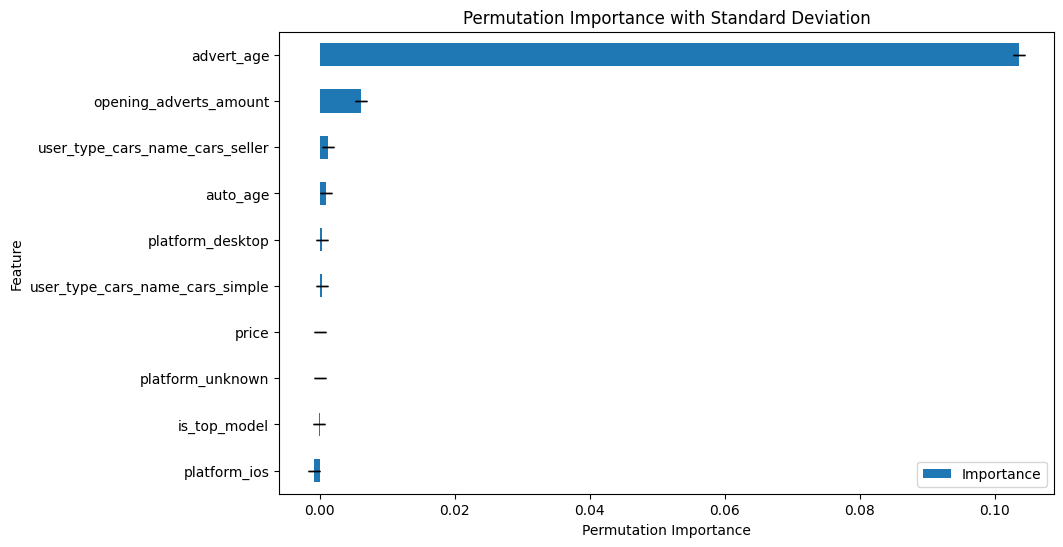

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(search_svm.best_estimator_, X_transformed, y, n_repeats=10, random_state=42)


feature_importance = pd.DataFrame({'Feature': X_transformed.columns,
                                   'Importance': result.importances_mean,
                                   'Standard Deviation': result.importances_std})
feature_importance = feature_importance.sort_values('Importance', ascending=True)


ax = feature_importance.plot(x='Feature', y='Importance', kind='barh', figsize=(10, 6), yerr='Standard Deviation', capsize=4)
ax.set_xlabel('Permutation Importance')
ax.set_title('Permutation Importance with Standard Deviation')